In [33]:
ds = xr.open_dataset(r"Data\Climate Data\4. Merged_Tas_Climate\Tas_Combined_Data.nc")
ds_node = ds.stack(node=("lat", "lon")).dropna(dim="node", how="all")
spei = ds_node["spei_1"].values  # (time, node)
T, N = spei.shape

# Keep only nodes with full coverage (no NaNs)
valid_counts = np.sum(np.isfinite(spei), axis=0)
good_nodes = valid_counts == T

ds_node_clean = ds_node.isel(node=good_nodes)
spei_clean = ds_node_clean["spei_1"].values  # (T_clean, N_clean)
T_clean, N_clean = spei_clean.shape
print("Clean SPEI:", T_clean, N_clean)


Clean SPEI: 396 2951


In [34]:
import numpy as np

# Drop time steps with any NaNs, just to be super safe
mask = np.isfinite(spei_clean)
valid_time_mask = np.all(mask, axis=1)
X = spei_clean[valid_time_mask, :]   # shape: (T_valid, N_clean)

print("X shape for corr:", X.shape)

# Correlation matrix between nodes (lag 0)
corr_mat = np.corrcoef(X.T)  # shape: (N_clean, N_clean)
print("Corr matrix shape:", corr_mat.shape)


X shape for corr: (396, 2951)
Corr matrix shape: (2951, 2951)


In [35]:
import pandas as pd

K = 10  # number of strongest connections per node
edges = []

for i in range(N_clean):
    # correlations from node i to all others
    row = corr_mat[i, :].copy()

    # remove self-correlation
    row[i] = -np.inf

    # get indices of top K correlations
    top_idx = np.argsort(row)[-K:]  # K largest values
    for j in top_idx:
        c = row[j]
        if np.isfinite(c) and c > 0:   # only keep positive links
            edges.append((i, j, float(c)))


In [36]:
edges_df = pd.DataFrame(edges, columns=["source", "target", "corr"])
print("Total edges:", len(edges_df))
print(edges_df.head())


Total edges: 29510
   source  target      corr
0       0      22  0.983409
1       0      23  0.988912
2       0      10  0.988975
3       0      25  0.989242
4       0       2  0.989738


In [37]:
edges_df = pd.DataFrame(edges, columns=["source", "target", "corr"])
print("Total edges:", len(edges_df))
print(edges_df.head())
edges_df.to_csv(r"Data\Climate Data\4. Merged_Tas_Climate\Tas_Combined_Data_CorrEdges.csv", index=False)

Total edges: 29510
   source  target      corr
0       0      22  0.983409
1       0      23  0.988912
2       0      10  0.988975
3       0      25  0.989242
4       0       2  0.989738


In [38]:
# For undirected interpretation, treat every row as bidirectional
strength = edges_df.groupby("source")["corr"].sum() + \
           edges_df.groupby("target")["corr"].sum()

strength = strength.groupby(strength.index).sum()  # ensure merge

# Fill full array
N_clean = ds_node_clean.sizes["node"]
strength_arr = np.zeros(N_clean)
strength_arr[strength.index.values] = strength.values

ds_node_clean["strength"] = ("node", strength_arr)


In [39]:
def autocorr_1_lag(x, lag):
    if lag == 0:
        return 1.0
    x_l = x[:-lag]
    y_l = x[lag:]
    mask = np.isfinite(x_l) & np.isfinite(y_l)
    if mask.sum() < 20:
        return np.nan
    return np.corrcoef(x_l[mask], y_l[mask])[0, 1]

lags_persist = [1, 2, 3]
T_clean, N_clean = spei_clean.shape
persistence = np.zeros((N_clean, len(lags_persist)))

for i in range(N_clean):
    x = spei_clean[:, i]
    for k, L in enumerate(lags_persist):
        persistence[i, k] = autocorr_1_lag(x, L)

self_persist = np.nanmean(persistence, axis=1)
ds_node_clean["self_persist"] = ("node", self_persist)


In [45]:
ds_maps = ds_node_clean[["strength", "self_persist"]].unstack("node")

# 🔧 Sort coordinates so xarray plotting is happy
ds_maps = ds_maps.sortby("lat").sortby("lon")
print(ds_maps)


<xarray.Dataset> Size: 108kB
Dimensions:       (lat: 81, lon: 82)
Coordinates:
  * lat           (lat) float64 648B -43.6 -43.55 -43.5 ... -39.65 -39.6 -39.45
  * lon           (lon) float64 656B 143.8 143.9 143.9 ... 148.3 148.3 148.4
Data variables:
    strength      (lat, lon) float64 53kB nan nan nan nan ... nan nan nan nan
    self_persist  (lat, lon) float64 53kB nan nan nan nan ... nan nan nan nan
Attributes:
    department:               Department of Environment and Science
    department_short:         DES
    copyright:                Copyright - the State of Queensland Department ...
    site_url:                 http://www.longpaddock.qld.gov.au
    institution:              Queensland Government, Department of Environmen...
    raster_source:            Gridded surface was created by interpolating ob...
    raster_source_additions:  and other suppliers (see the SILO webpage for d...
    metadata_url:             http://qldspatial.information.qld.gov.au/catalo...
    refer

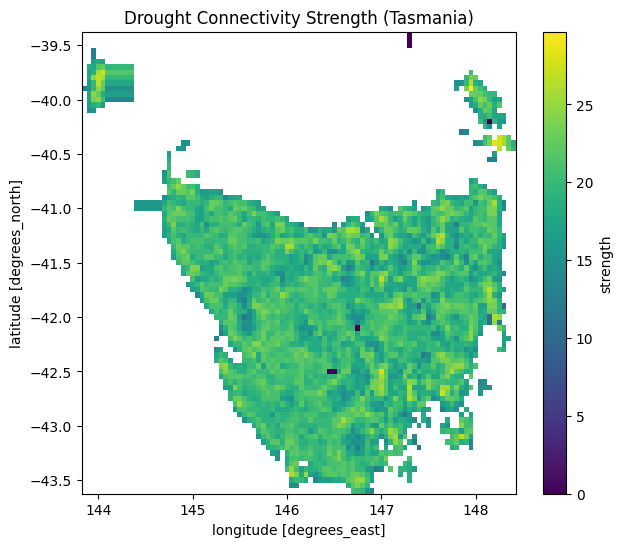

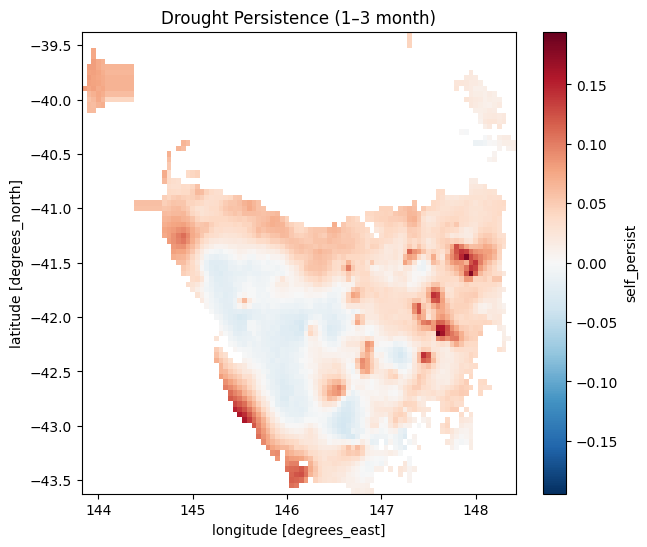

In [47]:
import matplotlib.pyplot as plt

ds_maps["strength"].plot(figsize=(7, 6))
plt.title("Drought Connectivity Strength (Tasmania)")
plt.show()

ds_maps["self_persist"].plot(figsize=(7, 6))
plt.title("Drought Persistence (1–3 month)")
plt.show()


In [48]:
ds_metrics = ds_node_clean[["strength", "self_persist"]].unstack("node")
print(ds_metrics)

# You can plot:
# ds_metrics["strength"].plot()
# ds_metrics["self_persist"].plot()

# ds_metrics.to_netcdf(
#     r"Data\Climate Data\4. Merged_Tas_Climate\Tas_drought_connectivity_metrics.nc"
# )


<xarray.Dataset> Size: 108kB
Dimensions:       (lat: 81, lon: 82)
Coordinates:
  * lat           (lat) float64 648B -43.6 -43.55 -43.5 ... -39.65 -39.6 -39.45
  * lon           (lon) float64 656B 146.7 146.8 146.8 ... 144.1 144.1 143.8
Data variables:
    strength      (lat, lon) float64 53kB 20.79 19.84 19.83 ... nan nan nan
    self_persist  (lat, lon) float64 53kB 0.01148 0.01513 0.01154 ... nan nan
Attributes:
    department:               Department of Environment and Science
    department_short:         DES
    copyright:                Copyright - the State of Queensland Department ...
    site_url:                 http://www.longpaddock.qld.gov.au
    institution:              Queensland Government, Department of Environmen...
    raster_source:            Gridded surface was created by interpolating ob...
    raster_source_additions:  and other suppliers (see the SILO webpage for d...
    metadata_url:             http://qldspatial.information.qld.gov.au/catalo...
    referen

In [49]:
print(ds_node_clean.dims)
print(ds_node_clean.data_vars)

# 1) Choose features
feature_names = ["monthly_rain", "max_temp", "min_temp", "radiation", "spi_1", "spei_1"]

# 2) Build feature tensor X [T, N, F]
feat_list = [ds_node_clean[name].values for name in feature_names]  # each [T, N]
X = np.stack(feat_list, axis=-1)  # [T, N, F]
print("X shape:", X.shape)  # (T, N, F)

# 3) Target: next-month SPEI-1
Y = ds_node_clean["spei_1"].values  # [T, N]
print("Y shape:", Y.shape)

# Optional: mask or standardise features over time
X_mean = np.nanmean(X, axis=(0,1), keepdims=True)
X_std = np.nanstd(X, axis=(0,1), keepdims=True)
X_norm = (X - X_mean) / (X_std + 1e-6)

# Replace any remaining NaN with 0 after normalisation
X_norm = np.nan_to_num(X_norm, nan=0.0)
Y = np.nan_to_num(Y, nan=0.0)

# Save preprocessed arrays for faster loading later
np.savez("tas_graph_data.npz", X=X_norm, Y=Y)


FrozenMappingWarningOnValuesAccess({'time': 396, 'node': 2951})
Data variables:
    spatial_ref   (time) float64 3kB ...
    monthly_rain  (time, node) float64 9MB 84.8 80.0 74.3 ... 39.3 37.0 44.9
    max_temp      (time, node) float64 9MB 17.68 18.23 19.12 ... 20.15 20.42
    min_temp      (time, node) float64 9MB 9.735 10.16 10.9 ... 12.68 12.7 14.04
    radiation     (time, node) float64 9MB 20.27 20.49 20.75 ... 21.18 22.17
    spi_1         (time, node) float64 9MB -0.9068 -0.9613 ... -0.5119 -0.182
    spei_1        (time, node) float64 9MB 0.3285 0.276 ... -0.1047 0.1714
    strength      (node) float64 24kB 20.79 19.84 19.83 ... 16.82 12.63 0.0
    self_persist  (node) float64 24kB 0.01148 0.01513 ... 0.07574 0.04401
X shape: (396, 2951, 6)
Y shape: (396, 2951)


In [50]:
import numpy as np

data = np.load("tas_graph_data.npz")
X = data["X"]  # [T, N, F]
Y = data["Y"]  # [T, N]


In [51]:
import numpy as np

# corr_mat: [N, N], computed earlier from ds_node_clean["spei_1"]
N = corr_mat.shape[0]

K = 10          # neighbours per node
min_corr = 0.2  # ignore very weak links

A = np.zeros((N, N), dtype=np.float32)

for i in range(N):
    row = corr_mat[i].copy()
    row[i] = -np.inf  # remove self
    
    # indices of top-K neighbours
    idx = np.argsort(row)[-K:]
    for j in idx:
        c = row[j]
        if c > min_corr:
            A[i, j] = c
            A[j, i] = c  # make symmetric

# Add self-loops
A_hat = A + np.eye(N, dtype=np.float32)

# GCN normalisation: D^{-1/2} A_hat D^{-1/2}
deg = np.sum(A_hat, axis=1)  # [N]
deg_inv_sqrt = np.power(deg, -0.5, where=deg>0)
deg_inv_sqrt[~np.isfinite(deg_inv_sqrt)] = 0.0

D_inv_sqrt = np.diag(deg_inv_sqrt)
A_norm = D_inv_sqrt @ A_hat @ D_inv_sqrt  # [N, N]
print("A_norm shape:", A_norm.shape)

# Save adjacency
np.save("tas_graph_A_norm.npy", A_norm)


A_norm shape: (2951, 2951)


In [52]:
import torch
from torch.utils.data import Dataset, DataLoader

class GraphTimeSeriesDataset(Dataset):
    def __init__(self, X, Y, window_len=6, t_start=0, t_end=None):
        """
        X: [T, N, F]
        Y: [T, N]
        We use windows [t-window_len+1, ..., t] to predict Y[t+1]
        Valid t indices: window_len-1 .. T-2
        Restrict to [t_start, t_end) in terms of target index (t+1).
        """
        self.X = X
        self.Y = Y
        self.window_len = window_len
        
        T = X.shape[0]
        if t_end is None:
            t_end = T - 1  # last usable target index is T-1
        
        # targets at indices: target_idx ∈ [t_start, t_end)
        # input window ends at target_idx - 1
        self.target_indices = list(range(max(t_start, window_len), t_end))
    
    def __len__(self):
        return len(self.target_indices)
    
    def __getitem__(self, idx):
        t_target = self.target_indices[idx]      # we predict Y[t_target]
        t_end = t_target - 1                     # input ends at t_end
        t_start = t_end - self.window_len + 1    # inclusive
        
        x_seq = self.X[t_start:t_end+1]  # [L, N, F]
        y_next = self.Y[t_target]        # [N]
        
        x_seq = torch.from_numpy(x_seq).float()
        y_next = torch.from_numpy(y_next).float()
        return x_seq, y_next

# Example splits along time
data = np.load("tas_graph_data.npz")
X = data["X"]  # [T, N, F]
Y = data["Y"]  # [T, N]
T = X.shape[0]

window_len = 6
# temporal split indices
t_train_end = int(0.7 * T)
t_val_end   = int(0.85 * T)

train_ds = GraphTimeSeriesDataset(X, Y, window_len=window_len,
                                  t_start=window_len, t_end=t_train_end)
val_ds   = GraphTimeSeriesDataset(X, Y, window_len=window_len,
                                  t_start=t_train_end, t_end=t_val_end)
test_ds  = GraphTimeSeriesDataset(X, Y, window_len=window_len,
                                  t_start=t_val_end, t_end=T-1)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False)


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphConvLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    
    def forward(self, X_t, A_norm):
        """
        X_t: [batch, N, F_in]
        A_norm: [N, N] (same for all batch samples)
        """
        # Graph convolution: A_norm @ X
        # First do matmul over node dimension
        # Convert A_norm to device and use batch matmul
        AX = torch.matmul(A_norm, X_t)  # [batch, N, F_in]
        out = self.linear(AX)           # [batch, N, F_out]
        return out


In [54]:
A_norm_np = np.load("tas_graph_A_norm.npy")
A_norm = torch.from_numpy(A_norm_np).float()  # put to device later


In [56]:
class GraphTemporalModel(nn.Module):
    def __init__(self, in_dim, gcn_hidden, gru_hidden, num_gcn_layers=1):
        super().__init__()
        self.num_gcn_layers = num_gcn_layers
        
        self.gcn1 = GraphConvLayer(in_dim, gcn_hidden)
        if num_gcn_layers > 1:
            self.gcn2 = GraphConvLayer(gcn_hidden, gcn_hidden)
        
        # GRU over time, per node
        # We'll input [L, batch*N, gcn_hidden] to GRU
        self.gru = nn.GRU(input_size=gcn_hidden,
                          hidden_size=gru_hidden,
                          num_layers=1,
                          batch_first=False)
        
        # Final MLP to map GRU output to scalar SPEI for each node
        self.fc_out = nn.Linear(gru_hidden, 1)
    
    def forward(self, x_seq, A_norm):
        """
        x_seq: [batch, L, N, F_in]
        A_norm: [N, N]
        Returns: y_pred [batch, N]
        """
        batch_size, L, N, F_in = x_seq.shape
        
        # Ensure A_norm has batch dimension for matmul
        # A_norm: [N, N] -> [batch, N, N]
        A = A_norm.unsqueeze(0).expand(batch_size, -1, -1)  # [batch, N, N]
        
        # Apply GCN to each time step
        gcn_outputs = []
        for t in range(L):
            X_t = x_seq[:, t, :, :]  # [batch, N, F_in]
            h = F.relu(self.gcn1(X_t, A))
            if self.num_gcn_layers > 1:
                h = F.relu(self.gcn2(h, A))
            gcn_outputs.append(h)  # each [batch, N, gcn_hidden]
        
        # Stack over time: [L, batch, N, gcn_hidden]
        H_seq = torch.stack(gcn_outputs, dim=0)
        
        # Prepare for GRU: merge batch & node into one dimension
        L_, B, N_, H_g = H_seq.shape  # L, batch, N, gcn_hidden
        H_seq_reshaped = H_seq.permute(0, 2, 1, 3)  # [L, N, batch, gcn_hidden]
        H_seq_reshaped = H_seq_reshaped.reshape(L_, N_ * B, H_g)  # [L, B*N, H_g]
        
        # GRU over time
        gru_out, _ = self.gru(H_seq_reshaped)  # [L, B*N, gru_hidden]
        last_out = gru_out[-1]                 # [B*N, gru_hidden]
        
        # Map to scalar per node
        y_flat = self.fc_out(last_out)         # [B*N, 1]
        y_flat = y_flat.squeeze(-1)            # [B*N]
        
        # Reshape back to [batch, N]
        y_pred = y_flat.view(N_, B).permute(1, 0)  # [batch, N]
        return y_pred


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
data = np.load("tas_graph_data.npz")
X = data["X"]  # [T, N, F]
Y = data["Y"]  # [T, N]
A_norm_np = np.load("tas_graph_A_norm.npy")

A_norm = torch.from_numpy(A_norm_np).float().to(device)

window_len = 6
T = X.shape[0]

t_train_end = int(0.7 * T)
t_val_end   = int(0.85 * T)

train_ds = GraphTimeSeriesDataset(X, Y, window_len, t_start=window_len, t_end=t_train_end)
val_ds   = GraphTimeSeriesDataset(X, Y, window_len, t_start=t_train_end, t_end=t_val_end)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False)

in_dim = X.shape[-1]
gcn_hidden = 32
gru_hidden = 32

model = GraphTemporalModel(in_dim, gcn_hidden, gru_hidden, num_gcn_layers=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(1, 51):
    model.train()
    train_loss = 0.0
    for x_seq, y_next in train_loader:
        x_seq = x_seq.to(device)   # [batch, L, N, F]
        y_next = y_next.to(device) # [batch, N]
        
        optimizer.zero_grad()
        y_pred = model(x_seq, A_norm)  # [batch, N]
        loss = criterion(y_pred, y_next)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * x_seq.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_seq, y_next in val_loader:
            x_seq = x_seq.to(device)
            y_next = y_next.to(device)
            y_pred = model(x_seq, A_norm)
            loss = criterion(y_pred, y_next)
            val_loss += loss.item() * x_seq.size(0)
    val_loss /= len(val_loader.dataset)
    
    print(f"Epoch {epoch:03d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")


Epoch 001: train_loss=0.9680, val_loss=1.0133
Epoch 002: train_loss=0.9574, val_loss=1.0067
Epoch 003: train_loss=0.9516, val_loss=0.9765
Epoch 004: train_loss=0.9431, val_loss=0.9799
Epoch 005: train_loss=0.9346, val_loss=0.9485
Epoch 006: train_loss=0.9216, val_loss=0.9290
Epoch 007: train_loss=0.9185, val_loss=0.9262
Epoch 008: train_loss=0.9108, val_loss=0.9286
Epoch 009: train_loss=0.9003, val_loss=0.9275
Epoch 010: train_loss=0.8934, val_loss=0.9047
Epoch 011: train_loss=0.8902, val_loss=0.9419
Epoch 012: train_loss=0.8942, val_loss=0.8808
Epoch 013: train_loss=0.8833, val_loss=0.8970
Epoch 014: train_loss=0.8774, val_loss=0.9202
Epoch 015: train_loss=0.8666, val_loss=0.8830
Epoch 016: train_loss=0.8629, val_loss=0.8940
Epoch 017: train_loss=0.8612, val_loss=0.9031
Epoch 018: train_loss=0.8721, val_loss=0.8699
Epoch 019: train_loss=0.8576, val_loss=0.8967
Epoch 020: train_loss=0.8612, val_loss=0.8901
Epoch 021: train_loss=0.8465, val_loss=0.8943
Epoch 022: train_loss=0.8462, val_

In [58]:
# --- After your existing train/val split ---
t_test_end = T  # till the end

test_ds = GraphTimeSeriesDataset(
    X, Y, window_len,
    t_start=t_val_end, 
    t_end=t_test_end
)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False)

# --- After training loop is finished ---
model.eval()
test_loss = 0.0

with torch.no_grad():
    for x_seq, y_next in test_loader:
        x_seq = x_seq.to(device)
        y_next = y_next.to(device)
        y_pred = model(x_seq, A_norm)
        loss = criterion(y_pred, y_next)
        test_loss += loss.item() * x_seq.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test MSE: {test_loss:.4f}")


Test MSE: 0.9976


In [59]:
import math
test_rmse = math.sqrt(test_loss)
print(f"Test RMSE: {test_rmse:.4f}")


Test RMSE: 0.9988


In [60]:
num_epochs = 50
train_history = []
val_history = []

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    for x_seq, y_next in train_loader:
        x_seq = x_seq.to(device)
        y_next = y_next.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x_seq, A_norm)
        loss = criterion(y_pred, y_next)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * x_seq.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_seq, y_next in val_loader:
            x_seq = x_seq.to(device)
            y_next = y_next.to(device)
            y_pred = model(x_seq, A_norm)
            loss = criterion(y_pred, y_next)
            val_loss += loss.item() * x_seq.size(0)
    val_loss /= len(val_loader.dataset)

    train_history.append(train_loss)
    val_history.append(val_loss)

    print(f"Epoch {epoch:03d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")


Epoch 001: train_loss=0.7601, val_loss=0.8679
Epoch 002: train_loss=0.7389, val_loss=0.8701
Epoch 003: train_loss=0.7343, val_loss=0.9054
Epoch 004: train_loss=0.7384, val_loss=0.8978
Epoch 005: train_loss=0.7204, val_loss=0.9160
Epoch 006: train_loss=0.7229, val_loss=0.8895
Epoch 007: train_loss=0.7316, val_loss=0.8956
Epoch 008: train_loss=0.7274, val_loss=0.9453
Epoch 009: train_loss=0.7181, val_loss=0.9007
Epoch 010: train_loss=0.7179, val_loss=0.9089
Epoch 011: train_loss=0.7045, val_loss=0.8978
Epoch 012: train_loss=0.7001, val_loss=0.9102
Epoch 013: train_loss=0.7058, val_loss=0.8968
Epoch 014: train_loss=0.7007, val_loss=0.8988
Epoch 015: train_loss=0.6981, val_loss=0.9277
Epoch 016: train_loss=0.6895, val_loss=0.9208
Epoch 017: train_loss=0.6858, val_loss=0.9369
Epoch 018: train_loss=0.6833, val_loss=0.9096
Epoch 019: train_loss=0.6846, val_loss=0.9386
Epoch 020: train_loss=0.6800, val_loss=0.8966
Epoch 021: train_loss=0.6730, val_loss=0.9033
Epoch 022: train_loss=0.6682, val_

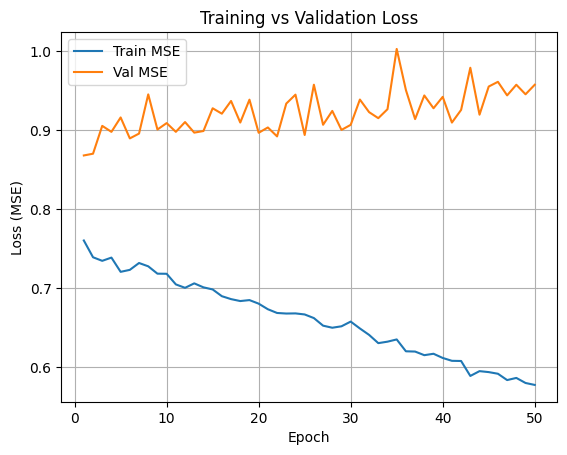

In [61]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, num_epochs + 1), train_history, label="Train MSE")
plt.plot(range(1, num_epochs + 1), val_history, label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [62]:
torch.save(model.state_dict(), "tas_graph_model.pth")
print("Model weights saved to tas_graph_model.pth")


Model weights saved to tas_graph_model.pth


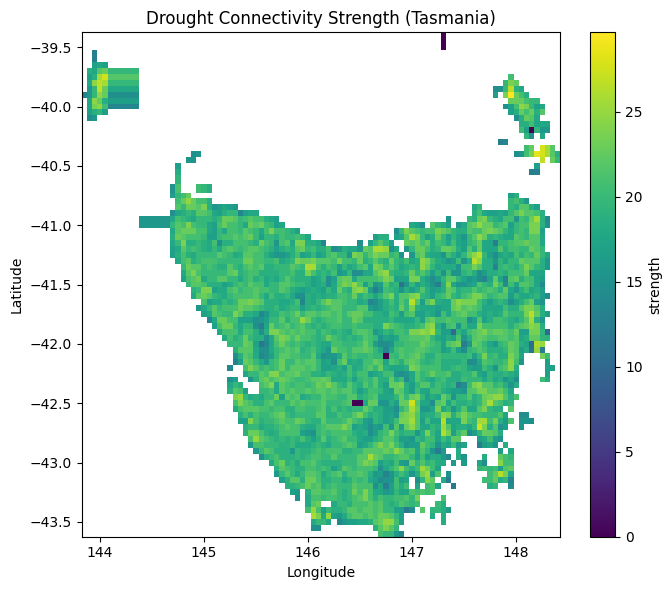

In [63]:
plt.figure(figsize=(7, 6))
ds_maps["strength"].plot()
plt.title("Drought Connectivity Strength (Tasmania)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


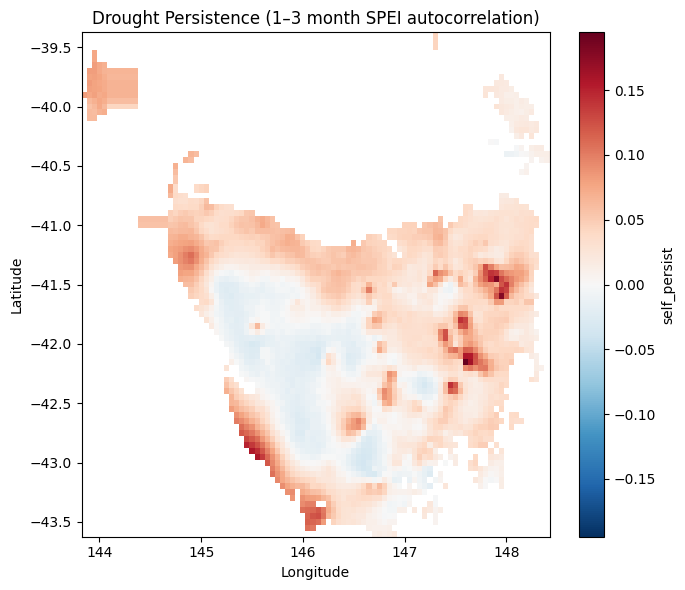

In [65]:
plt.figure(figsize=(7, 6))
ds_maps["self_persist"].plot()
plt.title("Drought Persistence (1–3 month SPEI autocorrelation)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


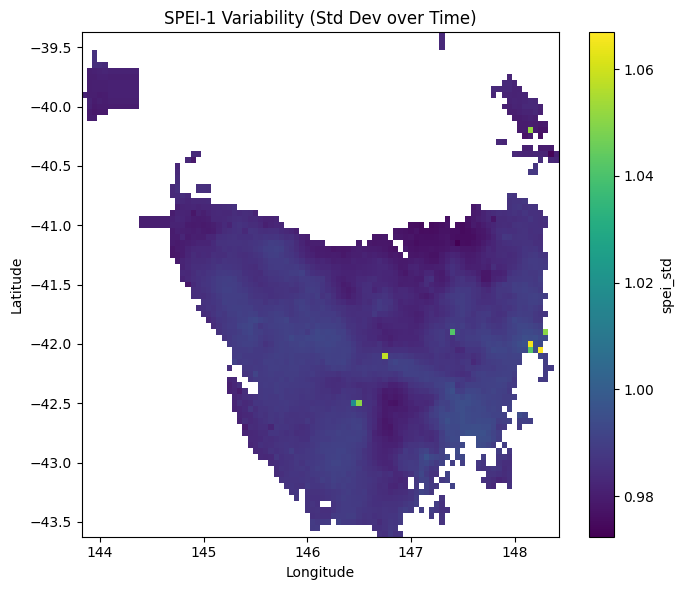

In [66]:
# SPEI variability from ds_node_clean, then unstack to lat-lon
spei = ds_node_clean["spei_1"]  # [time, node]
spei_std_node = spei.std(dim="time")        # [node]
ds_var = spei_std_node.to_dataset(name="spei_std").unstack("node")
ds_var = ds_var.sortby("lat").sortby("lon")

plt.figure(figsize=(7, 6))
ds_var["spei_std"].plot()
plt.title("SPEI-1 Variability (Std Dev over Time)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


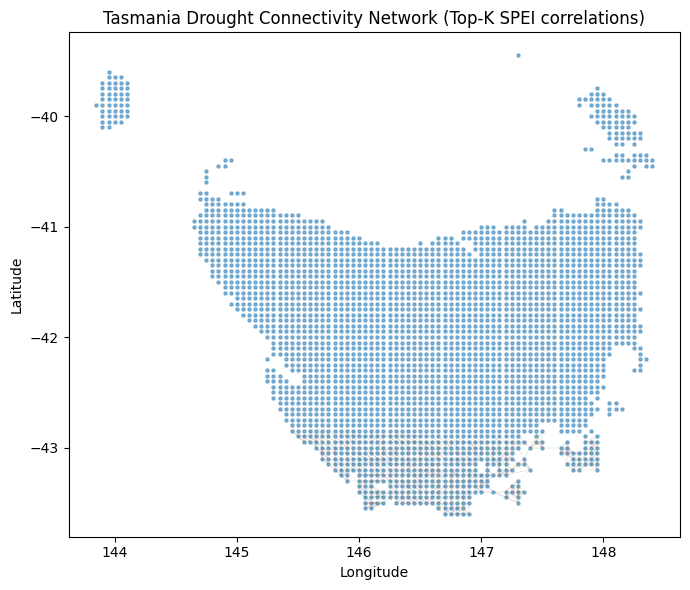

In [81]:
# Build edges (top-K per node) if not already in a DataFrame
N_clean = corr_mat.shape[0]
K = 5
min_corr = 0.1

edges = []
for i in range(N_clean):
    row = corr_mat[i].copy()
    row[i] = -np.inf
    idx = np.argsort(row)[-K:]
    for j in idx:
        c = row[j]
        if c > min_corr:
            edges.append((i, j, c))

# Node coordinates
lats = ds_node_clean["lat"].values
lons = ds_node_clean["lon"].values

# Plot
plt.figure(figsize=(7, 6))

# Scatter nodes
plt.scatter(lons, lats, s=5, alpha=0.5)

# Draw a subset of edges (e.g., first 2000)
max_edges_to_plot = 2000
for (i, j, c) in edges[:max_edges_to_plot]:
    x_vals = [lons[i], lons[j]]
    y_vals = [lats[i], lats[j]]
    plt.plot(x_vals, y_vals, linewidth=0.3, alpha=0.3)

plt.title("Tasmania Drought Connectivity Network (Top-K SPEI correlations)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


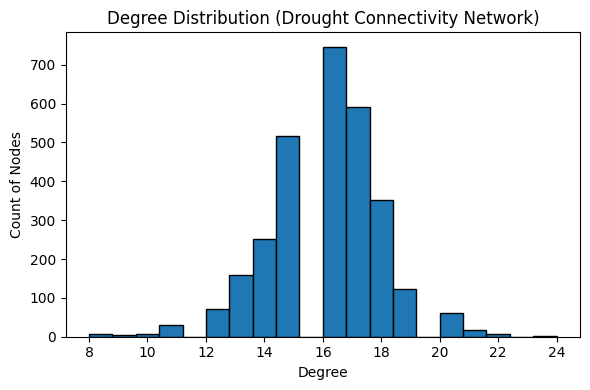

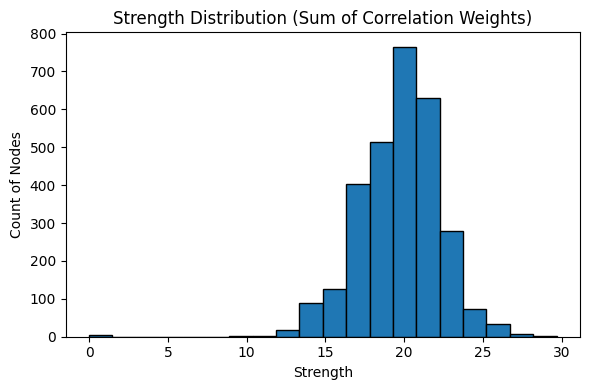

In [68]:
import pandas as pd

edges_df = pd.DataFrame(edges, columns=["source", "target", "corr"])

# Degree: count of neighbours per node
degree_series = edges_df["source"].value_counts().add(
    edges_df["target"].value_counts(), fill_value=0
)
degree_arr = np.zeros(N_clean)
degree_arr[degree_series.index.values] = degree_series.values

# If you already computed strength_arr:
# strength_arr = ds_node_clean["strength"].values

plt.figure(figsize=(6, 4))
plt.hist(degree_arr, bins=20, edgecolor="black")
plt.title("Degree Distribution (Drought Connectivity Network)")
plt.xlabel("Degree")
plt.ylabel("Count of Nodes")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(ds_node_clean["strength"].values, bins=20, edgecolor="black")
plt.title("Strength Distribution (Sum of Correlation Weights)")
plt.xlabel("Strength")
plt.ylabel("Count of Nodes")
plt.tight_layout()
plt.show()


In [71]:
p = np.load("tas_graph_data.npz")
y_true_all = p["y_true"]
y_pred_all = p["y_pred"]


# Choose a few node indices (manually or random)
node_ids = [10, 500, 1000]  # adjust within [0, N_clean)

time_axis = np.arange(y_true_all.shape[0])  # test time index

plt.figure(figsize=(10, 6))
for nid in node_ids:
    plt.plot(time_axis, y_true_all[:, nid], label=f"True node {nid}", linewidth=1)
    plt.plot(time_axis, y_pred_all[:, nid], "--", label=f"Pred node {nid}", linewidth=1)

plt.title("Predicted vs Actual SPEI-1 (Test period)")
plt.xlabel("Test Time Index")
plt.ylabel("SPEI-1")
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'y_true is not a file in the archive'

In [72]:
# RMSE for each node over test time
sq_err = (y_pred_all - y_true_all) ** 2  # [T_test, N]
rmse_node = np.sqrt(np.mean(sq_err, axis=0))  # [N]

# Attach to ds_node_clean and unstack
ds_node_perf = ds_node_clean.copy()
ds_node_perf["rmse_test"] = ("node", rmse_node)

ds_rmse = ds_node_perf[["rmse_test"]].unstack("node")
ds_rmse = ds_rmse.sortby("lat").sortby("lon")

plt.figure(figsize=(7, 6))
ds_rmse["rmse_test"].plot()
plt.title("Spatial RMSE of GNN SPEI-1 Prediction (Test period)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


NameError: name 'y_pred_all' is not defined

In [73]:
# Mean RMSE per time over nodes
rmse_time = np.sqrt(np.mean(sq_err, axis=1))  # [T_test]

plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(rmse_time)), rmse_time, marker="o", linewidth=1)
plt.title("Temporal RMSE of GNN SPEI-1 Prediction (Test period)")
plt.xlabel("Test Time Index")
plt.ylabel("RMSE (over all nodes)")
plt.tight_layout()
plt.show()


NameError: name 'sq_err' is not defined